# DATA 620, Homework 5 : Document Classification

### Group 1 Members:

* Mauricio Alarcon
* Sekhar Mekala 
* Aadi Kalloo
* Srinivasa Illapani
* Param Singh 

### Project Requirements

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  http://archive.ics.uci.edu/ml/datasets/Spambase

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

Your code and analysis should be delivered in an IPython Notebook by end of day Monday July 17th. 

## Dataset Description

Dataset obtained from: https://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html <br>
This data set is a collection of 20,000 messages, collected from 20 different netnews newsgroups. One thousand messages from each of the twenty newsgroups were chosen at random and partitioned by newsgroup name.

In [1]:
import os
import re
import math
import nltk
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, roc_curve, jaccard_similarity_score, precision_score
%matplotlib inline

In [26]:
rootdir = 'hw05/data/'

Create empty pandas dataframe. This will be used later on to store imported data:

In [27]:
df_ = pd.DataFrame(index=range(0), columns=['class', 'document'])
df_ = df_.fillna(0) # with 0s rather than NaNs

In [28]:
df_

,class,document


Data is organized into subfolders for each newsgroup. Loop through each subfolder and load contents of files into dataframe:

In [29]:
counter = 0
for subdir, dirs, files in os.walk(rootdir):
    folder_name = os.path.basename(subdir)
    for file in files:
        if not file.startswith('.'):
            f = open(subdir+'/'+file, 'r')
            txt = f.read()
            header_end = re.search(r'\n\n', txt)
            pos = header_end.start()
            strlen = len(txt)
            txt = txt[pos:strlen]
            df_ = df_.append({'class':folder_name, 'document':txt}, ignore_index=True)
            counter = counter + 1
            if counter % 500 == 0:
                print counter

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500


Perform simple data cleaning:

In [30]:
df_['document'] = df_['document'].str.replace('\n', '')

In [31]:
df_

,class,document
0,alt.atheism,Archive-name: atheism/resourcesAlt-atheism-arc...
1,alt.atheism,Archive-name: atheism/introductionAlt-atheism-...
2,alt.atheism,In article <65974@mimsy.umd.edu>mangoe@cs.umd....
3,alt.atheism,dmn@kepler.unh.edu (...until kings become phil...
4,alt.atheism,In article <N4HY.93Apr5120934@harder.ccr-p.ida...
5,alt.atheism,In article <1993Apr5.091139.823@batman.bmd.trw...
6,alt.atheism,arromdee@jyusenkyou.cs.jhu.edu (Ken Arromdee) ...
7,alt.atheism,In article <114127@bu.edu>jaeger@buphy.bu.edu ...
8,alt.atheism,(reference line trimmed)livesey@solntze.wpd.sg...
9,alt.atheism,kmr4@po.CWRU.edu (Keith M. Ryan) writes:>>Then...


Shuffle rows of dataframe and split into training and test data sets:

In [32]:
data1 = df_
shuffled_indices = np.random.permutation(np.arange(len(data1)))
data1 = data1.reset_index(drop=True)
train_proportion = 0.8

shuffled_df = data1.reindex(np.random.permutation(data1.index))
shuffled_df = shuffled_df.reset_index(drop=True)
df_train = shuffled_df[0:int(math.floor(train_proportion*len(shuffled_df)))]
df_test = shuffled_df[int(math.floor(train_proportion*len(shuffled_df))+1):len(shuffled_df)]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Define functions that will be used later -- one that cleans a body of text and one that analyzes performance:

In [33]:
def review_to_words(raw_review):
    review_text = BeautifulSoup(raw_review).get_text()    
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    words = letters_only.lower().split()                             
    stops = set(nltk.corpus.stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

def perf_measure(y_actual, y_hat, metric=[]):
    TN, TP, FN, TP = confusion_matrix(y_actual, y_hat).ravel()

    if metric == 'sensitivity':
        return TP/(TP+FP)
    elif metric == 'specificity':
        return TN/(TN+FN)
    else:
        return(TP, FP, TN, FN)

In [34]:
stopwords = nltk.corpus.stopwords.words('english')


Clean each news article:

In [36]:
num_paths_train = df_train["document"].size
num_paths_test = df_test["document"].size
#print num_paths_test
clean_paths_train = []
clean_paths_test = []

for i in xrange(0, num_paths_train):
    clean_paths_train.append(review_to_words(df_train["document"][i]))

for i in xrange(0, num_paths_test):
    clean_paths_test.append(review_to_words(df_test["document"][i]))


/Users/aadi/Python2Anaconda/anaconda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Create vector arrays of ngram presence (1-6 words) for each news article:

In [37]:
collapsed_train = ' '.join(clean_paths_train)
print 'vectorizing'
vectorizer = CountVectorizer(analyzer = "word",ngram_range=(1,6),tokenizer = None,preprocessor = None,stop_words = None, max_features=10000) 
print 'transforming'
train_data_features = vectorizer.fit_transform(clean_paths_train)
print 'transforming complete'
train_data_features = train_data_features.toarray()
vocab = vectorizer.get_feature_names()
dist = np.sum(train_data_features, axis=0)
for tag, count in zip(vocab, dist):
    print count, tag

vectorizing
transforming
transforming complete
117 aa
67 aaa
82 aaron
232 ab
42 ab virginia
42 ab virginia edu
41 ab virginia edu andi
41 ab virginia edu andi beyer
39 ab virginia edu andi beyer writes
104 abc
81 abiding
334 ability
1313 able
41 able find
84 able get
42 able use
41 abort
356 abortion
81 abortions
48 aboutthe
53 abraham
51 abs
69 absence
266 absolute
310 absolutely
63 absolutes
72 abstract
107 absurd
41 abu
192 abuse
47 abuses
970 ac
54 ac il
50 ac nz
433 ac uk
48 ac za
65 acad
42 acad alaska
40 acad alaska edu
127 academic
45 acc
58 accelerated
60 acceleration
89 accelerator
603 accept
192 acceptable
67 acceptance
256 accepted
63 accepting
52 accepts
1022 access
131 access digex
106 access digex com
48 access digex com pat
43 access digex com pat writes
172 accident
71 accidental
40 accidentally
86 accidents
55 accomplish
61 accomplished
59 accord
658 according
374 account
142 accounts
148 accuracy
236 accurate
46 accurately
42 accuse
69 accused
49 ace
89 achieve
75 ac

Order most common ngrams by frequency:

In [38]:
from operator import itemgetter
f = zip(vocab, dist)
sorted(f,key=itemgetter(1), reverse=True)

[(u'ax', 52937),
 (u'ax ax', 47764),
 (u'ax ax ax', 42943),
 (u'ax ax ax ax', 38356),
 (u'ax ax ax ax ax', 34027),
 (u'ax ax ax ax ax ax', 30024),
 (u'would', 11859),
 (u'one', 11823),
 (u'writes', 11786),
 (u'edu', 11752),
 (u'article', 10078),
 (u'com', 7812),
 (u'like', 7756),
 (u'people', 7682),
 (u'know', 6941),
 (u'get', 6434),
 (u'think', 6035),
 (u'also', 5755),
 (u'time', 5289),
 (u'use', 5088),
 (u'could', 4518),
 (u'good', 4513),
 (u'new', 4507),
 (u'well', 4486),
 (u'even', 4301),
 (u'see', 4149),
 (u'may', 4127),
 (u'max', 4064),
 (u'way', 4022),
 (u'us', 3924),
 (u'god', 3918),
 (u'two', 3813),
 (u'make', 3812),
 (u'first', 3777),
 (u'much', 3755),
 (u'many', 3712),
 (u'right', 3693),
 (u'say', 3678),
 (u'ax max', 3664),
 (u'max ax', 3658),
 (u'max ax ax', 3602),
 (u'ax ax max', 3567),
 (u'ax max ax', 3546),
 (u'max ax ax ax', 3500),
 (u'ax max ax ax', 3493),
 (u'ax ax ax max', 3483),
 (u'ax ax max ax', 3453),
 (u'max ax ax ax ax', 3428),
 (u'ax ax max ax ax', 3406),
 (u'

### Training the Classifier

In [39]:
print "Training the random forest..."
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, df_train["class"] )
print 'Training complete'

Training the random forest...
Training complete


In [40]:
# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_paths_test)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

### Classification Performance

In [41]:
accuracy_score(df_test['class'], result)

0.73893473368342089

In [42]:
cohen_kappa_score(df_test['class'], result)

0.72517410650691883

In [43]:
jaccard_similarity_score(df_test['class'], result)

0.73893473368342089

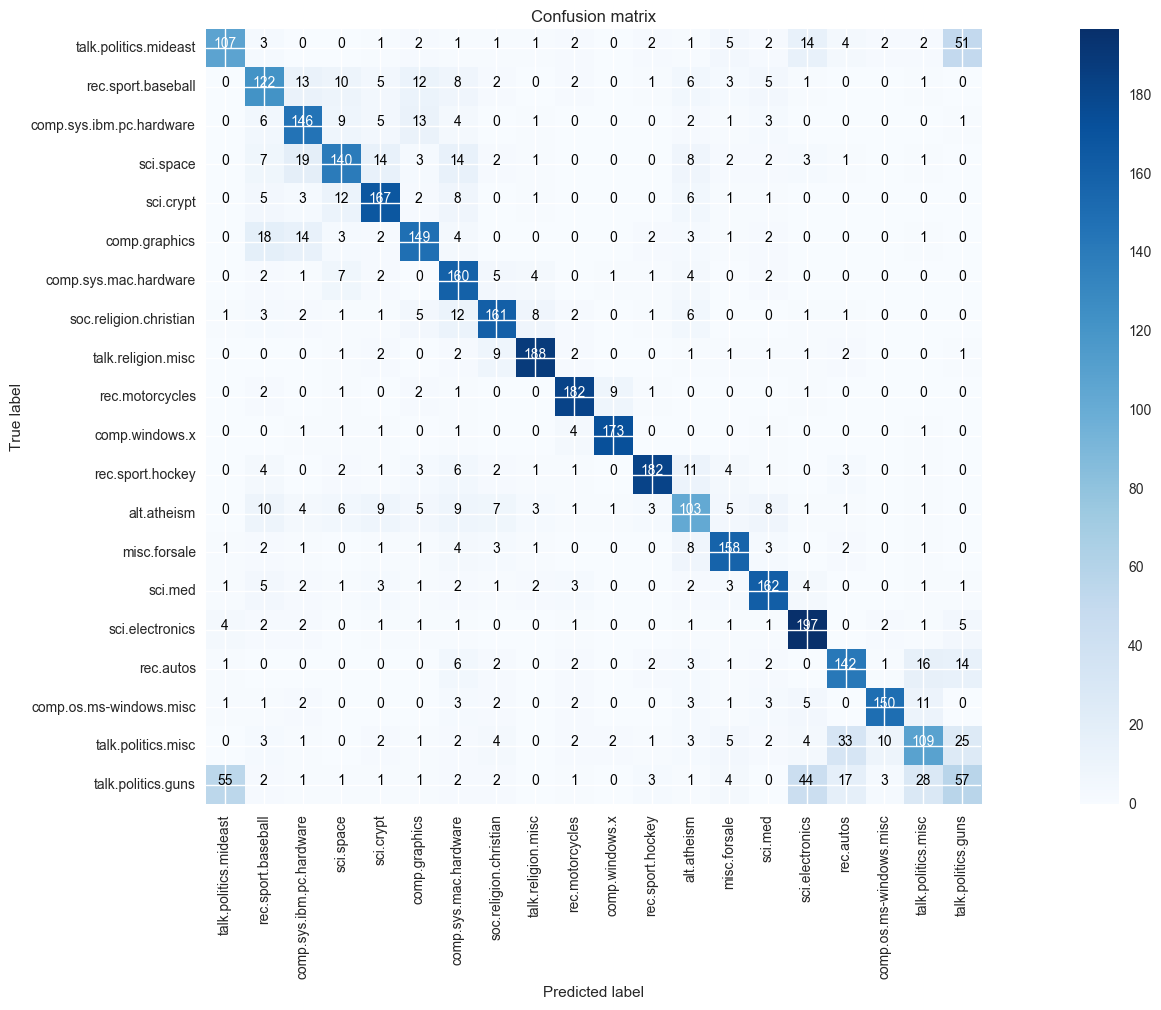

In [44]:
def plot_confusion_matrix(classes, cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cmatrix = confusion_matrix(df_test['class'], result)
plt.figure(figsize=(20,10))
plot_confusion_matrix(df_train['class'].unique(),cmatrix)
plt.show()